<a href="https://colab.research.google.com/github/Wazib/CNN_FakeNews/blob/main/CNN_FakeNews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Code

>Specifying TensorFlow version to version 1.0

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
import tensorflow
print(tensorflow.__version__)

1.15.2


In [ ]:
from __future__ import division, print_function
from gensim import models
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout, Reshape, Flatten, concatenate, Input, Conv1D, GlobalMaxPooling1D, Embedding
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from keras import backend as K 
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import os
import collections
import re
import string

Using TensorFlow backend.


In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
data = pd.read_csv('gdrive/My Drive/Data Sets/Fake News/FakeNewsNet.csv',engine='python',index_col=False)

In [ ]:
data.columns = ['ID', 'URL', 'Text', 'Source', 'Label']

In [ ]:
data.head()

,ID,URL,Text,Source,Label
0,gossipcop-2493749932,www.dailymail.co.uk/tvshowbiz/article-5874213/...,Did Miley Cyrus and Liam Hemsworth secretly ge...,gossipcop,fake
1,gossipcop-4580247171,hollywoodlife.com/2018/05/05/paris-jackson-car...,Paris Jackson & Cara Delevingne Enjoy Night Ou...,gossipcop,fake
2,gossipcop-941805037,variety.com/2017/biz/news/tax-march-donald-tru...,Celebrities Join Tax March in Protest of Donal...,gossipcop,fake
3,gossipcop-2547891536,www.dailymail.co.uk/femail/article-3499192/Do-...,Cindy Crawford's daughter Kaia Gerber wears a ...,gossipcop,fake
4,gossipcop-5476631226,variety.com/2018/film/news/list-2018-oscar-nom...,Full List of 2018 Oscar Nominations â€“ Variety,gossipcop,fake


In [ ]:
data.Label.unique()

array(['fake', 'real'], dtype=object)

In [ ]:
data.shape

(22866, 5)

# Selecting Gossipcop/ Politifact text

In [ ]:
#Selecting Gossipcop text
datag=data.loc[data['Source']=='politifact']

In [ ]:
datag.head()

,ID,URL,Text,Source,Label
21871,politifact15014,speedtalk.com/forum/viewtopic.php?t=51650,BREAKING: First NFL Team Declares Bankruptcy O...,politifact,fake
21872,politifact15156,politics2020.info/index.php/2018/03/13/court-o...,Court Orders Obama To Pay $400 Million In Rest...,politifact,fake
21873,politifact14745,www.nscdscamps.org/blog/category/parenting/467...,UPDATE: Second Roy Moore Accuser Works For Mic...,politifact,fake
21874,politifact14355,https://howafrica.com/oscar-pistorius-attempts...,Oscar Pistorius Attempts To Commit Suicide,politifact,fake
21875,politifact15371,http://washingtonsources.org/trump-votes-for-d...,Trump Votes For Death Penalty For Being Gay,politifact,fake


In [ ]:
data=datag

In [ ]:
#Reset the index
data.reset_index(inplace = True)

#Code Resumes

In [ ]:
real = []
fake = []
for l in data.Label:
    if l == "fake":
        real.append(0)
        fake.append(1)
    elif l == "real":
        real.append(1)
        fake.append(0)

In [ ]:
data['Real']= real
data['Fake']= fake

In [ ]:
data.head()

,index,ID,URL,Text,Source,Label,Real,Fake
0,21871,politifact15014,speedtalk.com/forum/viewtopic.php?t=51650,BREAKING: First NFL Team Declares Bankruptcy O...,politifact,fake,0,1
1,21872,politifact15156,politics2020.info/index.php/2018/03/13/court-o...,Court Orders Obama To Pay $400 Million In Rest...,politifact,fake,0,1
2,21873,politifact14745,www.nscdscamps.org/blog/category/parenting/467...,UPDATE: Second Roy Moore Accuser Works For Mic...,politifact,fake,0,1
3,21874,politifact14355,https://howafrica.com/oscar-pistorius-attempts...,Oscar Pistorius Attempts To Commit Suicide,politifact,fake,0,1
4,21875,politifact15371,http://washingtonsources.org/trump-votes-for-d...,Trump Votes For Death Penalty For Being Gay,politifact,fake,0,1


In [ ]:
def remove_punct(text):
    text_nopunct = ''
    text_nopunct = re.sub('['+string.punctuation+']', '', text)
    return text_nopunct

data['Text_Clean'] = data['Text'].apply(lambda x: remove_punct(x))

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
from nltk import word_tokenize, WordNetLemmatizer
tokens = [word_tokenize(sen) for sen in data.Text_Clean]

In [ ]:
def lower_token(tokens): 
    return [w.lower() for w in tokens]    
    
lower_tokens = [lower_token(token) for token in tokens]

In [ ]:
from nltk.corpus import stopwords
stoplist = stopwords.words('english')

In [ ]:
def remove_stop_words(tokens): 
    return [word for word in tokens if word not in stoplist]

In [ ]:
filtered_words = [remove_stop_words(sen) for sen in lower_tokens]

In [ ]:
result = [' '.join(sen) for sen in filtered_words]

In [ ]:
data['Text_Final'] = result

In [ ]:
data['tokens'] = filtered_words

In [ ]:
data = data[['Text_Final', 'tokens', 'Label', 'Real', 'Fake']]

In [ ]:
data.head()

,Text_Final,tokens,Label,Real,Fake
0,breaking first nfl team declares bankruptcy kn...,"[breaking, first, nfl, team, declares, bankrup...",fake,0,1
1,court orders obama pay 400 million restitution,"[court, orders, obama, pay, 400, million, rest...",fake,0,1
2,update second roy moore accuser works michelle...,"[update, second, roy, moore, accuser, works, m...",fake,0,1
3,oscar pistorius attempts commit suicide,"[oscar, pistorius, attempts, commit, suicide]",fake,0,1
4,trump votes death penalty gay,"[trump, votes, death, penalty, gay]",fake,0,1


In [ ]:
data_train, data_test = train_test_split(data, test_size=0.10, random_state=42)

In [ ]:
all_training_words = [word for tokens in data_train["tokens"] for word in tokens]
training_sentence_lengths = [len(tokens) for tokens in data_train["tokens"]]
TRAINING_VOCAB = sorted(list(set(all_training_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_training_words), len(TRAINING_VOCAB)))
print("Max sentence length is %s" % max(training_sentence_lengths))

6440 words total, with a vocabulary size of 3145
Max sentence length is 35


In [ ]:
all_test_words = [word for tokens in data_test["tokens"] for word in tokens]
test_sentence_lengths = [len(tokens) for tokens in data_test["tokens"]]
TEST_VOCAB = sorted(list(set(all_test_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_test_words), len(TEST_VOCAB)))
print("Max sentence length is %s" % max(test_sentence_lengths))

705 words total, with a vocabulary size of 550
Max sentence length is 17


In [ ]:
import pickle
with open('/content/gdrive/My Drive/Fani/GoogleNewsModel.pickle', 'rb') as f:
  modelX = pickle.load(f)

#Preparing keyed vector word_vectors from model
word2vec = modelX.wv

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  


In [ ]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, clean_comments, generate_missing=False):
    embeddings = clean_comments['tokens'].apply(lambda x: get_average_word2vec(x, vectors, 
                                                                                generate_missing=generate_missing))
    return list(embeddings)

In [ ]:
training_embeddings = get_word2vec_embeddings(word2vec, data_train, generate_missing=True)

In [ ]:
MAX_SEQUENCE_LENGTH = 50
EMBEDDING_DIM = 300

In [ ]:
tokenizer = Tokenizer(num_words=len(TRAINING_VOCAB), lower=True, char_level=False)
tokenizer.fit_on_texts(data_train["Text_Final"].tolist())
training_sequences = tokenizer.texts_to_sequences(data_train["Text_Final"].tolist())

train_word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(train_word_index))

Found 3145 unique tokens.


In [ ]:
train_cnn_data = pad_sequences(training_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [ ]:
train_embedding_weights = np.zeros((len(train_word_index)+1, EMBEDDING_DIM))
for word,index in train_word_index.items():
    train_embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
print(train_embedding_weights.shape)

(3146, 300)


In [ ]:
test_sequences = tokenizer.texts_to_sequences(data_test["Text_Final"].tolist())
test_cnn_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [ ]:
#Method 1
'''
def ConvNet(embeddings, max_sequence_length, num_words, embedding_dim, labels_index):
    
    embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embeddings],
                            input_length=max_sequence_length,
                            trainable=False)
    
    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    convs = []
    filter_sizes = [2,3,4,5,6]

    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=200, kernel_size=filter_size, activation='relu')(embedded_sequences)
        l_pool = GlobalMaxPooling1D()(l_conv)
        convs.append(l_pool)


    l_merge = concatenate(convs, axis=1)

    x = Dropout(0.1)(l_merge)  
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    preds = Dense(labels_index, activation='sigmoid')(x)

    model = Model(sequence_input, preds)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])
    model.summary()
    return model
'''

"\ndef ConvNet(embeddings, max_sequence_length, num_words, embedding_dim, labels_index):\n    \n    embedding_layer = Embedding(num_words,\n                            embedding_dim,\n                            weights=[embeddings],\n                            input_length=max_sequence_length,\n                            trainable=False)\n    \n    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')\n    embedded_sequences = embedding_layer(sequence_input)\n\n    convs = []\n    filter_sizes = [2,3,4,5,6]\n\n    for filter_size in filter_sizes:\n        l_conv = Conv1D(filters=200, kernel_size=filter_size, activation='relu')(embedded_sequences)\n        l_pool = GlobalMaxPooling1D()(l_conv)\n        convs.append(l_pool)\n\n\n    l_merge = concatenate(convs, axis=1)\n\n    x = Dropout(0.1)(l_merge)  \n    x = Dense(128, activation='relu')(x)\n    x = Dropout(0.2)(x)\n    preds = Dense(labels_index, activation='sigmoid')(x)\n\n    model = Model(sequence_input, preds)\n

In [ ]:
#Method 2
def ConvNet(embeddings, max_sequence_length, num_words, embedding_dim, labels_index):
    
    embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embeddings],
                            input_length=max_sequence_length,
                            trainable=False)
    
    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    convs = []
    filter_sizes = [2,3,4]

    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=300, kernel_size=filter_size, activation='relu')(embedded_sequences)
        l_pool = GlobalMaxPooling1D()(l_conv)
        convs.append(l_pool)


    l_merge = concatenate(convs, axis=1)

    x = Dropout(0.1)(l_merge)  
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.2)(x)
    preds = Dense(labels_index, activation='sigmoid')(x)

    model = Model(sequence_input, preds)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])
    model.summary()
    return model

In [ ]:
label_names = ['Real', 'Fake']

In [ ]:
y_train = data_train[label_names].values

In [ ]:
x_train = train_cnn_data
y_tr = y_train

In [ ]:
model = ConvNet(train_embedding_weights, MAX_SEQUENCE_LENGTH, len(train_word_index)+1, EMBEDDING_DIM, 
                len(list(label_names)))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 50, 300)      943800      input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 49, 300)      180300      embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D

#Train CNN

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [ ]:
num_epochs = 10
batch_size = 64

In [ ]:
hist = model.fit(x_train, y_tr, epochs=num_epochs, validation_split=0.1, callbacks=[es], shuffle=True, batch_size=batch_size)


Train on 805 samples, validate on 90 samples
Epoch 1/10
805/805 [==============================] - 5s 6ms/step - loss: 0.6603 - acc: 0.6217 - val_loss: 0.5354 - val_acc: 0.8167
Epoch 2/10
805/805 [==============================] - 5s 6ms/step - loss: 0.4270 - acc: 0.8311 - val_loss: 0.3926 - val_acc: 0.8556
Epoch 3/10
805/805 [==============================] - 5s 6ms/step - loss: 0.2588 - acc: 0.9050 - val_loss: 0.3485 - val_acc: 0.8778
Epoch 4/10
805/805 [==============================] - 4s 5ms/step - loss: 0.1516 - acc: 0.9491 - val_loss: 0.3700 - val_acc: 0.8222
Epoch 5/10
805/805 [==============================] - 4s 5ms/step - loss: 0.0879 - acc: 0.9733 - val_loss: 0.4444 - val_acc: 0.8222
Epoch 00005: early stopping


#Test CNN

In [ ]:
predictions = model.predict(test_cnn_data, batch_size=1024, verbose=1)

100/100 [==============================] - 0s 2ms/step


In [ ]:
labels = [1, 0]

In [ ]:
yhat=[]
for p in predictions:
    yhat.append(labels[np.argmax(p)])

In [ ]:
prediction_labels=[]
for p in yhat:
    if p==0:
        prediction_labels.append("fake")
    elif p==1:
        prediction_labels.append("real")

In [ ]:
y_test=[]
for p in data_test.Label:
    if p=="real":
        y_test.append(1)
    elif p=="fake":
        y_test.append(0)

>Finding the Accuracy

In [ ]:
sum(data_test.Label==prediction_labels)/len(prediction_labels)

0.8

In [ ]:
comp_label={"Actual":y_test, "Predicted":yhat}

In [ ]:
dfp=pd.DataFrame(comp_label)

In [ ]:
dfp

,Actual,Predicted
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1
...,...,...
95,1,1
96,1,1
97,1,1
98,0,0


In [ ]:
data_test.Label.value_counts()

real    56
fake    44
Name: Label, dtype: int64

Confusion Matrix :
[[24 20]
 [ 0 56]]
Accuracy Score : 0.8
AUC:  0.9391233766233765
Report : 
              precision    recall  f1-score   support

           0       1.00      0.55      0.71        44
           1       0.74      1.00      0.85        56

    accuracy                           0.80       100
   macro avg       0.87      0.77      0.78       100
weighted avg       0.85      0.80      0.79       100



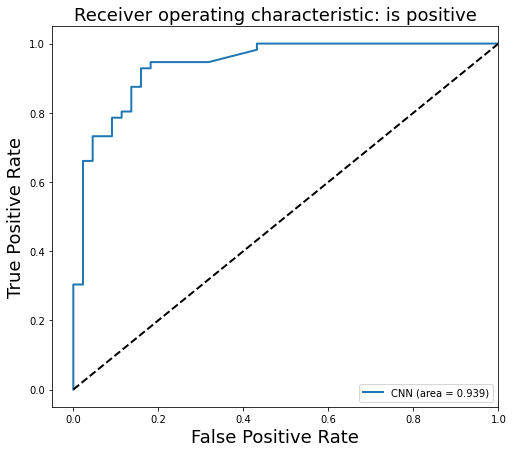

In [ ]:
from sklearn.metrics import roc_curve, auc
from itertools import chain
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
import matplotlib.pyplot as plt
#Method 1
#fpr, tpr, threshold = roc_curve(y_test, predictions[:,1])
fpr, tpr, threshold = roc_curve(y_test, predictions[:,0])
#Method 2
#fpr, tpr, threshold = roc_curve(y_test, yhat)
roc_auc = auc(fpr, tpr)

#This part is for the confusion matrix and accuracy score
cf_matrix = confusion_matrix(y_test, yhat) 
print ('Confusion Matrix :')
print(cf_matrix) 
print ('Accuracy Score :',accuracy_score(y_test, yhat))
print("AUC: ", roc_auc)
print ('Report : ')
print (classification_report(y_test, yhat) )
#

plt.figure(figsize=(8,7))
plt.plot(fpr, tpr, label='CNN (area = %0.3f)' % roc_auc, linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic: is positive', fontsize=18)
plt.legend(loc="lower right")
plt.show()